In [242]:
# Use logistic regression to predict adult incomes
# Data resource: Kaggle (https://www.kaggle.com/flyingwombat/logistic-regression-with-uci-adult-income/data)

In [243]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cross_validation as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [244]:
# Load local csv data into pandas DataFrame
income_df = pd.read_csv("data/income_data.csv")
income_df_list =  list(income_df)
print income_df_list
print income_df.shape

['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
(48842, 15)


In [245]:
income_df.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
31003,31,Private,199883,12th,8,Divorced,Transport-moving,Own-child,White,Male,0,0,40,United-States,<=50K
33299,42,Self-emp-inc,27187,Masters,14,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States,>50K
1030,23,Private,211345,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,40,Nicaragua,<=50K
26844,23,State-gov,103588,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,United-States,<=50K
47557,65,?,52728,Some-college,10,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K


In [246]:
# get some basic ideas about the data
def summerize_data_by_group(df):
    for column in df.columns:
        print column
        if df.dtypes[column] == np.object: # Categorical data
            print df[column].value_counts()
        else:
            print df[column].describe() 
            
        print '\n'
    
summerize_data_by_group(income_df) 

age
count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


fnlwgt
count    4.884200e+04
mean     1.896641e+05
std      1.056040e+05
min      1.228500e+04
25%      1.175505e+05
50%      1.781445e+05
75%      2.376420e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64


education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6t

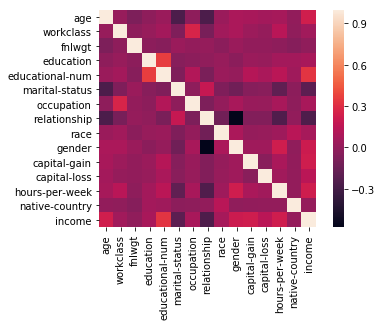

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
48838,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
48839,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
48840,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0
48841,52,5,287927,11,9,2,4,5,4,0,15024,0,40,39,1


In [247]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(income_df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

encoded_data.tail(5)

In [248]:
# Expore the strong correaltion between "education" and "education-num" revealed by the heatmap
income_df[["education", "educational-num"]].head(10)

,education,educational-num
0,11th,7
1,HS-grad,9
2,Assoc-acdm,12
3,Some-college,10
4,Some-college,10
5,10th,6
6,HS-grad,9
7,Prof-school,15
8,Some-college,10
9,7th-8th,4


In [249]:
# "education" and "education-num" are essentially the same data, delete the numerical one
del income_df["educational-num"]

In [250]:
income_df.head(1) # Successfully deleted!

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K


In [251]:
# Check the negative correlation between "gender" and "relationship"
income_df[["gender", "relationship"]].head(10)

,gender,relationship
0,Male,Own-child
1,Male,Husband
2,Male,Husband
3,Male,Husband
4,Female,Own-child
5,Male,Not-in-family
6,Male,Unmarried
7,Male,Husband
8,Female,Unmarried
9,Male,Husband


In [252]:
# It looks like "Female" and "wife" and anti-correlated, so are "Male" and "Husband"

In [253]:
encoded_data, encoders = number_encode_features(income_df)
new_series = encoded_data["income"]

In [254]:
# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("income")], new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [255]:
# logistic regression
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

In [256]:
print accuracy_score(y_test, y_pred)

0.7956049955640483


In [257]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [258]:
print fit_and_evaluate(cls)

0.20439500443595168


In [259]:
# Try random forest method
random_forest = RandomForestRegressor(random_state=60)

In [260]:
print fit_and_evaluate(random_forest)

0.19312996201


Index([u'age', u'workclass', u'fnlwgt', u'education', u'marital-status',
       u'occupation', u'relationship', u'race', u'gender', u'capital-gain',
       u'capital-loss', u'hours-per-week', u'native-country'],
      dtype='object')


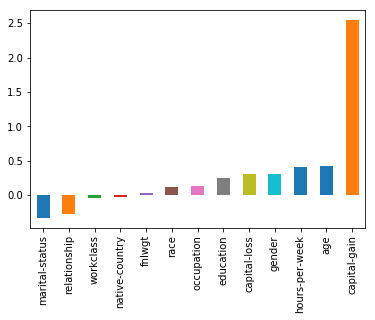

capital-gain      2.541568
age               0.427784
hours-per-week    0.410400
gender            0.305525
capital-loss      0.300793
education         0.242181
occupation        0.127933
race              0.124951
fnlwgt            0.038483
native-country   -0.024813
workclass        -0.039884
relationship     -0.275408
marital-status   -0.330784
dtype: float64


In [261]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print X_train.columns
coefs = coefs.sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()
print coefs.sort_values(ascending = False)

In [262]:
# Try one hot encoding

# Copy the original data
features = income_df.copy()

# Select the numeric columns
numeric_subset = income_df.select_dtypes('number')
categorical_subset = income_df.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("income")])

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
print features.head()

   age  fnlwgt  capital-gain  capital-loss  hours-per-week  workclass_?  \
0   25  226802             0             0              40            0   
1   38   89814             0             0              50            0   
2   28  336951             0             0              40            0   
3   44  160323          7688             0              40            0   
4   18  103497             0             0              30            1   

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                      0                    0                       0   
1                      0                    0                       0   
2                      0                    1                       0   
3                      0                    0                       0   
4                      0                    0                       0   

   workclass_Private            ...              native-country_Portugal  \
0                  1            ..

In [263]:
# Replace the inf with nan
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
features = features.dropna()

# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [264]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print accuracy_score(y_test, y_pred)

0.8527946495598171


In [265]:
print fit_and_evaluate(cls)

0.1472053504401829


In [266]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print coefs.sort_values(ascending = False)

capital-gain                                 2.404515
marital-status_Married-civ-spouse            0.815193
hours-per-week                               0.354006
age                                          0.339787
education_Bachelors                          0.290162
capital-loss                                 0.272589
education_Masters                            0.262526
occupation_Exec-managerial                   0.253365
education_Doctorate                          0.208138
education_Prof-school                        0.208067
relationship_Wife                            0.207394
relationship_Not-in-family                   0.186855
occupation_Prof-specialty                    0.178623
gender_Male                                  0.175246
workclass_Federal-gov                        0.101838
relationship_Unmarried                       0.088037
occupation_Tech-support                      0.081319
fnlwgt                                       0.075501
occupation_Sales            

In [267]:
# Further group numerical predictors such as "age" or "hours-per-week" to gain more insight!
# Group the "age" column
age_group = []
for age in income_df["age"]:
    if age < 25:
        age_group.append("<25")
    elif 25 <= age <= 34:
        age_group.append("25-34")
    elif 34 < age <= 44:
        age_group.append("35-44")
    elif 44 < age <= 54:
        age_group.append("45-54")
    elif 54 < age <= 65:
        age_group.append("55-64")
    else:
        age_group.append("65 and over")

In [268]:
new_income_df = income_df.copy()
new_income_df["age_group"] = age_group
del new_income_df["age"]

# Same thing for "hours-per-week"
work_hours_per_week = []
for hours in income_df["hours-per-week"]:
    if hours < 16:
        work_hours_per_week.append("<16")
    elif 16 <= hours <= 32:
        work_hours_per_week.append("16-32")
    elif 32 < hours <= 48:
        work_hours_per_week.append("32-48")
    elif 48 < hours <= 60:
        work_hours_per_week.append("48-60")
    else:
        work_hours_per_week.append("60 and over")
        
new_income_df["work_hours_per_week"] = work_hours_per_week
del new_income_df["hours-per-week"]

new_income_df.head(1)

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,native-country,income,age_group,work_hours_per_week
0,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,United-States,<=50K,25-34,32-48


In [269]:
# Apply one-hot-encoding to the new dataframe

# Select the numeric columns
numeric_subset = new_income_df.select_dtypes('number')
categorical_subset = new_income_df.select_dtypes('object')

# One hot encoding
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("income")])

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
print features.head()

   fnlwgt  capital-gain  capital-loss  workclass_?  workclass_Federal-gov  \
0  226802             0             0            0                      0   
1   89814             0             0            0                      0   
2  336951             0             0            0                      0   
3  160323          7688             0            0                      0   
4  103497             0             0            1                      0   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                    0                       0                  1   
1                    0                       0                  1   
2                    1                       0                  0   
3                    0                       0                  1   
4                    0                       0                  0   

   workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                       0                           0   
1       

In [270]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
cls.fit(X_train, y_train)
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print coefs.sort_values(ascending = False)

capital-gain                            2.299783
marital-status_Married-civ-spouse       0.732685
age_group_45-54                         0.307429
education_Bachelors                     0.290761
capital-loss                            0.264893
education_Masters                       0.242276
occupation_Exec-managerial              0.224575
relationship_Wife                       0.216778
age_group_35-44                         0.216196
education_Prof-school                   0.212611
work_hours_per_week_48-60               0.209526
education_Doctorate                     0.203839
gender_Male                             0.176399
age_group_55-64                         0.157181
occupation_Prof-specialty               0.150518
relationship_Not-in-family              0.131415
fnlwgt                                  0.099150
workclass_Federal-gov                   0.091840
native-country_United-States            0.086148
occupation_Tech-support                 0.080817
occupation_Protectiv

In [271]:
# Follow-up work: optimize the hyperparameters of random forest model
